# Analyzing LTE-mode power consumption and production

This file aims to analyze the relation between calculated counters and other 
variables from the cic_data table.
The goal is to formulate how to estimate the counters when cic was in LTE mode.

In [1]:
import pymysql.cursors
from urllib.parse import urlparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# get data from MySQL table
mysql_url = os.environ["MYSQLDEV"]
parsed_mysql_url = urlparse(mysql_url)

try:
    connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                user=parsed_mysql_url.username,
                                password=parsed_mysql_url.password,
                                database=parsed_mysql_url.path[1:],
                                port=parsed_mysql_url.port,
                                autocommit=True)
    cursor = connection.cursor()
    if cursor.connection:
        try:
            sql_statement = f"SELECT cic_id, `time`, quattBuild, hp1_data_availability, hp2_data_availability, OLD_hp1_electrical_energy_counter, OLD_hp1_thermal_energy_counter, OLD_hp2_electrical_energy_counter, OLD_hp2_thermal_energy_counter, OLD_cv_energy_counter, hp1_energy_consumed, hp1_heat_generated, hp2_energy_consumed, hp2_heat_generated, boiler_heat_generated FROM cic_data WHERE created_at > '2023-08-11'"
            cursor.execute(sql_statement)
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
        except pymysql.Error as err:
            print("Error while executing script {err}", exc_info=True)
except:
    print("Error while connecting to MySQL")
finally:
    cursor.close()
    connection.close()

## overview of data in mysql table

In [3]:
df = pd.DataFrame(result)

In [4]:
# calculate difference in counters
df['OLD_hp1_electrical_energy_counter_diff'] = df.sort_values(['cic_id','time']).groupby('cic_id')['OLD_hp1_electrical_energy_counter'].diff()
df['OLD_hp2_electrical_energy_counter_diff'] = df.sort_values(['cic_id','time']).groupby('cic_id')['OLD_hp2_electrical_energy_counter'].diff()
df['OLD_hp1_thermal_energy_counter_diff'] = df.sort_values(['cic_id','time']).groupby('cic_id')['OLD_hp1_thermal_energy_counter'].diff()
df['OLD_hp2_thermal_energy_counter_diff'] = df.sort_values(['cic_id','time']).groupby('cic_id')['OLD_hp2_thermal_energy_counter'].diff()
df['OLD_cv_energy_counter_diff'] = df.sort_values(['cic_id','time']).groupby('cic_id')['OLD_cv_energy_counter'].diff()

# 
df['new_model'] = df['quattBuild'].str.startswith('2', na=False).astype(int)
df['recalculated'] = (~(df['quattBuild'].str.startswith('0.00.1', na=False)) &
                    ~(df['quattBuild'].str.startswith('0.00.2', na=False)) & 
                    ~(df['quattBuild'].str.startswith('0.00.3', na=False))).astype(int)

In [5]:
def get_LTE_model(df, xcol, ycol, fit_intercept_var=False):
    # set X_train and y_train
    X = df[xcol]
    y = df[ycol]

    # test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # fit model
    linreg = LinearRegression(fit_intercept=fit_intercept_var)
    linreg.fit(X_train.values.reshape(-1, 1), y_train)

    # Evaluate test model
    print("Coefficients = ", list(linreg.coef_) + [linreg.intercept_])
    y_train_pred = linreg.predict(X_train.values.reshape(-1, 1))
    print("rmse = ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("mae = ", mean_absolute_error(y_train, y_train_pred))

    # evaluate model
    y_pred = linreg.predict(X_test.values.reshape(-1, 1))

    # Evaluate
    print("rmse = ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("mae = ", mean_absolute_error(y_test, y_pred))
    print("r2 = ", r2_score(y_test, y_pred))
    return linreg

In [6]:
def plot_LTE_estimator(df, xcol, ycol, linreg, limit=(0, 1000)):
    
    # plot unfiltered data
    ax = df.plot.scatter(x=xcol,
                    y=ycol,
                    figsize=(10, 5),
                    s=2,
                    c = 'g',
                    label = 'unfiltered')
    
    # plot filtered old model, original data
    df[(df['new_model']==0) &
       (df['recalculated']==0) &
            (df[f'{xcol}_outlier']==0) &
            (df[f'{ycol}_outlier']==0) & 
            (df[f'{xcol}'] > 0) &
            (df[f'{ycol}'] > 0)].plot.scatter(x=xcol, 
                                             y=ycol, 
                                             figsize=(10, 5), 
                                             s=2, 
                                             c = 'b',
                                             label = '<0.00.38',
                                             ax=ax)
    df[(df['new_model']==0) &
       (df['recalculated']==1) &
            (df[f'{xcol}_outlier']==0) &
            (df[f'{ycol}_outlier']==0) & 
            (df[f'{xcol}'] > 0) &
            (df[f'{ycol}'] > 0)].plot.scatter(x=xcol, 
                                             y=ycol, 
                                             figsize=(10, 5), 
                                             s=2, 
                                             c = 'c',
                                             label = '0.00.38 - 2.x.x',
                                             ax=ax)
    # plot filtered new model data
    df[(df['new_model']==1)  &
       (df[f'{xcol}_outlier']==0) &
        (df[f'{ycol}_outlier']==0) & 
        (df[f'{xcol}'] > 0) &
        (df[f'{ycol}'] > 0)].plot.scatter(x=xcol,
                                        y=ycol,
                                        figsize=(10, 5),
                                        s=2,
                                        c = 'r',
                                        label = '2.x.x - ...',
                                        ax=ax)

    ax.plot(df[xcol], linreg.predict(df[[xcol]]), color='black', linewidth=3)
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.legend()
    ax.set_xlim(limit)
    ax.set_ylim(limit)
    plt.grid()
    plt.title(f'{xcol} vs {ycol}')
    plt.suptitle(f'y = {linreg.intercept_} + {linreg.coef_[0]} * x')
    plt.show()
    return


In [7]:
# Flag outliers
def flag_outlier(df, col, threshold=20):
    """
    Flag outliers in a column of a dataframe
    :param df: dataframe
    :param col: column name
    :return: dataframe with new column of outliers based on IQR
    """
    IQR = df[col].astype('float').quantile(0.75) - df[col].astype('float').quantile(0.25)
    IQR = df[(df[col].notna()) & ~(df[col]==0)][col].astype('float').quantile(0.75) - df[(df[col].notna()) & ~(df[col]==0)][col].astype('float').quantile(0.25)
    print(f'IQR for {col}: {IQR}')
    lower_fence = df[(df[col].notna()) & ~(df[col]==0)][col].astype('float').quantile(0.25) - (IQR * threshold)
    print(f'Lower fence for {col}: {lower_fence}')
    upper_fence = df[(df[col].notna()) & ~(df[col]==0)][col].astype('float').quantile(0.75) + (IQR * threshold)
    print(f'Upper fence for {col}: {upper_fence}')
    df[f'{col}_outlier'] = np.where((df[col] < lower_fence) | (df[col] > upper_fence), 1, 0)
    return df

## HP LTE mode
Electrical energy consumed:  
- 0, when !hpConnected
- 5.15, when hp1.active=0 and hpConnected
- MAX(0, 2.73 * (counter_End - counter_Start)), when hpConnected and hp1.active > 0

Heat energy produced:
- 0, when !hpConnected or hp.active=0
- 2.18 * (counter_End - counter_Start), when hpConnected and hp.active > 0

CV:
- 0, when cv.active = 0
- MAX(0, 2.18 * (counter_End - counter_start)), when cv.active > 0

IQR for hp1_energy_consumed: 0.0017139999999997713
Lower fence for hp1_energy_consumed: 4.978479000000023
Upper fence for hp1_energy_consumed: 5.322992999999977
IQR for NEW_hp1_electrical_energy_counter_diff: 5.0
Lower fence for NEW_hp1_electrical_energy_counter_diff: -505.15
Upper fence for NEW_hp1_electrical_energy_counter_diff: 499.85
Coefficients =  [1.131328793796724, 0.0]
rmse =  4.629330962969314
mae =  4.210200304388004
rmse =  4.391314665740727
mae =  4.205520002819699
r2 =  -422280.5832852288


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


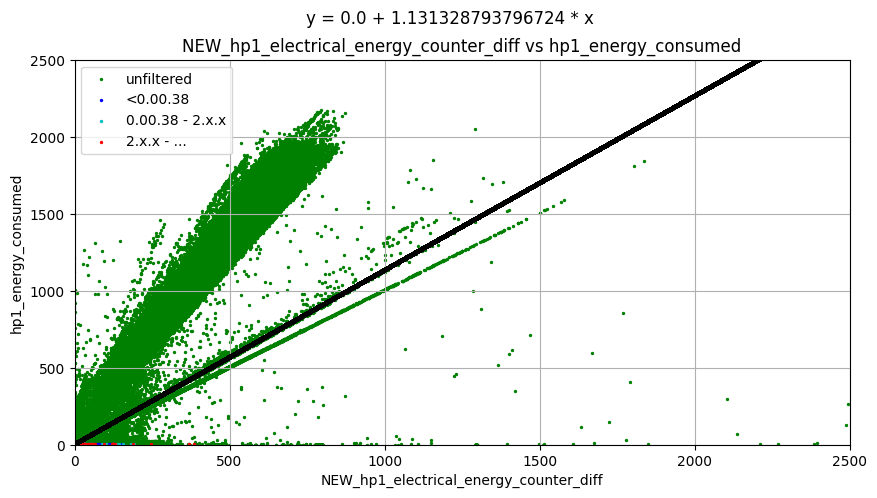

In [11]:
# compensate counters for missing standby consumption
df['NEW_hp1_electrical_energy_counter_diff'] = df['OLD_hp1_electrical_energy_counter_diff'].astype(float) - (5.15)
df['NEW_hp2_electrical_energy_counter_diff'] = df['OLD_hp2_electrical_energy_counter_diff'].astype(float) - (5.15)

# model for hp1 power consumed
df = flag_outlier(df, 'hp1_energy_consumed', 100)
df = flag_outlier(df, 'NEW_hp1_electrical_energy_counter_diff', 100)

# get LTE model
hp1_electrical_model = get_LTE_model(df[(df['hp1_data_availability']>0) &
                                    # (df['hp2_data_availability']==0) &
                                    (df['NEW_hp1_electrical_energy_counter_diff'].notna()) &
                                    (df['hp1_energy_consumed'].notna()) &
                                    (df['NEW_hp1_electrical_energy_counter_diff_outlier']==0) & 
                                    (df['hp1_energy_consumed_outlier']==0) & 
                                    (df['hp1_energy_consumed'] > 0) &
                                    (df['NEW_hp1_electrical_energy_counter_diff'] > 0)],
                                'NEW_hp1_electrical_energy_counter_diff',
                                'hp1_energy_consumed')

# plot overview
plot_LTE_estimator(df[(df['hp1_data_availability']>0) &
                    # (df['hp2_data_availability']==0) &
                    (df['NEW_hp1_electrical_energy_counter_diff'].notna()) &
                    (df['hp1_energy_consumed'].notna())],
                'NEW_hp1_electrical_energy_counter_diff',
                'hp1_energy_consumed',
                hp1_electrical_model,
                limit=[0,2500])



IQR for hp1_heat_generated: 2213.1010399999996
Lower fence for hp1_heat_generated: -31900.34233649999
Upper fence for hp1_heat_generated: 36705.789903499994
IQR for OLD_hp1_thermal_energy_counter_diff: 977.960323
Lower fence for OLD_hp1_thermal_energy_counter_diff: -14092.112685
Upper fence for OLD_hp1_thermal_energy_counter_diff: 16224.657328000001
Coefficients =  [2.1650510443623436, 0.0]
rmse =  420.59505624547614
mae =  193.70869295711387
rmse =  427.6021477731783
mae =  192.6729622755925
r2 =  0.9043304074349787


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


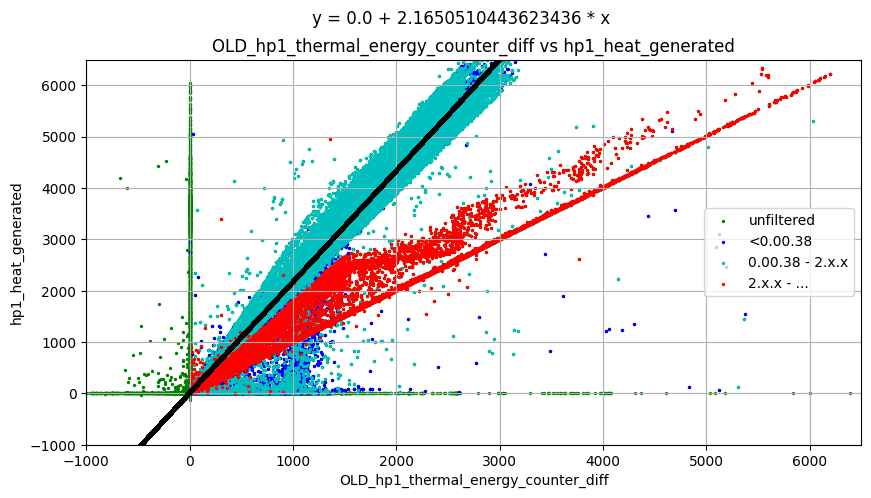

In [9]:
# model for hp1 heat generated
df = flag_outlier(df, 'hp1_heat_generated', 15)
df = flag_outlier(df, 'OLD_hp1_thermal_energy_counter_diff', 15)

# get LTE model
hp1_thermal_model = get_LTE_model(df[(df['hp1_data_availability']>0) &
                                    (df['hp2_data_availability']==0) &
                                    (df['OLD_hp1_thermal_energy_counter_diff'].notna()) &
                                    (df['hp1_heat_generated'].notna()) &
                                    (df['OLD_hp1_thermal_energy_counter_diff_outlier']==0) & 
                                    (df['hp1_heat_generated_outlier']==0) & 
                                    (df['hp1_heat_generated'] > 0) &
                                    (df['OLD_hp1_thermal_energy_counter_diff'] > 0) &
                                    (df['recalculated']==1)],
                                'OLD_hp1_thermal_energy_counter_diff',
                                'hp1_heat_generated')

# plot overview
plot_LTE_estimator(df[(df['hp1_data_availability']>0) &
                    (df['hp2_data_availability']==0) &
                    (df['OLD_hp1_thermal_energy_counter_diff'].notna()) &
                    (df['hp1_heat_generated'].notna())],
                'OLD_hp1_thermal_energy_counter_diff',
                'hp1_heat_generated',
                hp1_thermal_model,
                limit=[-1000,6500])


## CV heat production

IQR for boiler_heat_generated: 1395.58822925
Lower fence for boiler_heat_generated: -6908.18617075
Upper fence for boiler_heat_generated: 8443.284351


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_8048/494759900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_outlier'] = np.where((df[col] < lower_fence) | (df[col] > upper_fence), 1, 0)


IQR for OLD_cv_energy_counter_diff: 404.44830325
Lower fence for OLD_cv_energy_counter_diff: -2024.48687
Upper fence for OLD_cv_energy_counter_diff: 2424.44446575


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_8048/494759900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_outlier'] = np.where((df[col] < lower_fence) | (df[col] > upper_fence), 1, 0)


Coefficients =  [2.223938647970524, 73.40074485394143]
rmse =  251.56447807820157
mae =  143.25420926353334
rmse =  253.48311041998568
mae =  143.96595971261453
r2 =  0.9615260700290311


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


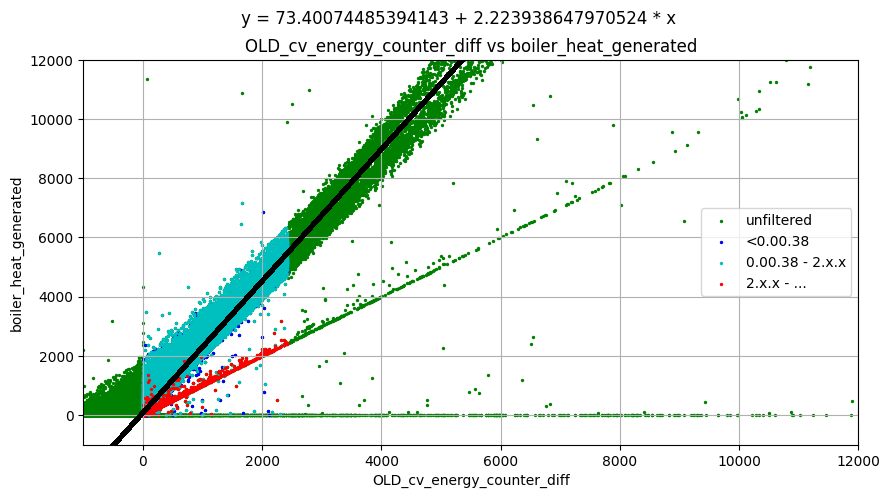

In [10]:
# model for hp2 power consumed
df = flag_outlier(df[df['boiler_heat_generated'].notna()], 'boiler_heat_generated', 5)
df = flag_outlier(df[df['OLD_cv_energy_counter_diff'].notna()], 'OLD_cv_energy_counter_diff', 5)

# get LTE model
cv_model = get_LTE_model(df[(df['hp1_data_availability']>0) &
                            (df['OLD_cv_energy_counter_diff'].notna()) &
                            (df['boiler_heat_generated'].notna()) &
                            (df['OLD_cv_energy_counter_diff_outlier']==0) & 
                            (df['boiler_heat_generated_outlier']==0) & 
                            (df['boiler_heat_generated'] > 0) &
                            (df['OLD_cv_energy_counter_diff'] > 0)],
                        'OLD_cv_energy_counter_diff',
                        'boiler_heat_generated',
                        fit_intercept_var=True)

# plot overview
plot_LTE_estimator(df[(df['hp1_data_availability']>0) &
                    (df['OLD_cv_energy_counter_diff'].notna()) &
                    (df['boiler_heat_generated'].notna())],
                'OLD_cv_energy_counter_diff',
                'boiler_heat_generated',
                cv_model,
                limit=[-1000,12000])

## Check hpt

In [167]:
df[df['hp1_heat_generated']>12000]

,cic_id,time,quattBuild,hp1_data_availability,hp2_data_availability,OLD_hp1_electrical_energy_counter,OLD_hp1_thermal_energy_counter,OLD_hp2_electrical_energy_counter,OLD_hp2_thermal_energy_counter,OLD_cv_energy_counter,...,OLD_hp1_electrical_energy_counter_diff_outlier,hp1_energy_consumed_outlier,new_model,hp1_heat_generated_outlier,OLD_hp1_thermal_energy_counter_diff_outlier,recalculated,hp2_energy_consumed_outlier,OLD_hp2_electrical_energy_counter_diff_outlier,boiler_heat_generated_outlier,OLD_cv_energy_counter_diff_outlier
11672,CIC-05fbece6-7f21-5ab8-bdcd-6670029f1b39,2022-11-22 18:00:00,0.00.10dev,1,0,10542.250028,51762.958244,None,None,28359.206708,...,0,0,0,0,0,0,0,0,1,1
13614,CIC-05fbece6-7f21-5ab8-bdcd-6670029f1b39,2022-12-03 17:00:00,0.00.10dev,1,0,35344.077444,185804.573487,None,None,60039.087973,...,0,0,0,0,0,0,0,0,1,1
14541,CIC-05fbece6-7f21-5ab8-bdcd-6670029f1b39,2022-11-20 11:00:00,0.00.10dev,1,0,1219.968472,4635.333206,None,None,5217.206219,...,0,0,0,0,0,0,0,0,1,1
14714,CIC-05fbece6-7f21-5ab8-bdcd-6670029f1b39,2022-11-19 16:00:00,0.00.10dev,1,0,1419.957500,5549.024481,None,None,6089.099953,...,0,0,0,0,0,0,0,0,1,1
14759,CIC-05fbece6-7f21-5ab8-bdcd-6670029f1b39,2022-12-18 13:00:00,0.00.10dev,1,0,107214.115333,522710.429290,None,None,134828.822051,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212609,CIC-0b5dcc89-bb27-5bd7-8c82-34c8878e5e5d,2022-12-10 19:00:00,0.00.26,0,0,3.777944,0.000000,None,None,0.000000,...,0,0,0,0,0,0,0,0,0,0
213722,CIC-1da11ccd-d818-5f7e-a954-654e4c504530,2022-12-13 08:00:00,0.00.26,1,0,86099.107750,316895.563545,None,None,97233.360789,...,0,0,0,0,0,0,0,0,1,1
217066,CIC-0b5dcc89-bb27-5bd7-8c82-34c8878e5e5d,2022-12-13 03:00:00,0.00.26,1,0,210.945083,0.000000,None,None,0.000000,...,0,0,0,0,0,0,0,0,0,0
426591,CIC-c0c3f6e9-f97b-570b-ab9f-8d02a9b56ca4,2023-03-24 07:00:00,0.00.25,1,0,282121.844389,1265712.325618,None,None,469581.497397,...,0,0,0,0,0,0,0,0,1,1


## hp2

Coefficients =  [0.9966040956009352, 0.0]
rmse =  0.3505875426873017
mae =  0.2624808409077827
rmse =  0.3653656166233923
mae =  0.273079608477241


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


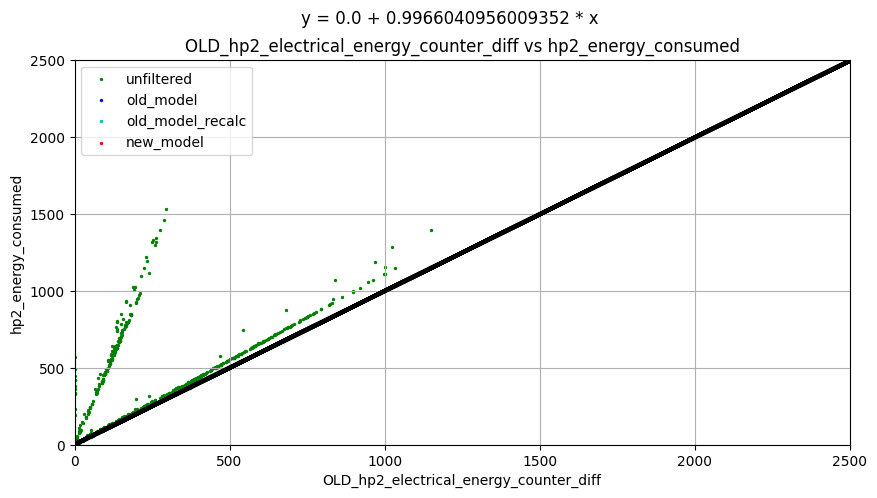

In [125]:
# model for hp2 power consumed
df = flag_outlier(df, 'hp2_energy_consumed', 15)
df = flag_outlier(df, 'OLD_hp2_electrical_energy_counter_diff', 15)

# get LTE model
hp2_electrical_model = get_LTE_model(df[(df['hp2_data_availability']>0) &
                                    # (df['hp2_data_availability']==0) &
                                    (df['OLD_hp2_electrical_energy_counter_diff'].notna()) &
                                    (df['hp2_energy_consumed'].notna()) &
                                    (df['OLD_hp2_electrical_energy_counter_diff_outlier']==0) & 
                                    (df['hp2_energy_consumed_outlier']==0) & 
                                    (df['hp2_energy_consumed'] > 0) &
                                    (df['OLD_hp2_electrical_energy_counter_diff'] > 0)],
                                'OLD_hp2_electrical_energy_counter_diff',
                                'hp2_energy_consumed')

# plot overview
plot_LTE_estimator(df[(df['hp2_data_availability']>0) &
                    # (df['hp2_data_availability']==0) &
                    (df['OLD_hp2_electrical_energy_counter_diff'].notna()) &
                    (df['hp2_energy_consumed'].notna())],
                'OLD_hp2_electrical_energy_counter_diff',
                'hp2_energy_consumed',
                hp2_electrical_model,
                limit=[0,2500])



IndexError: invalid index to scalar variable.

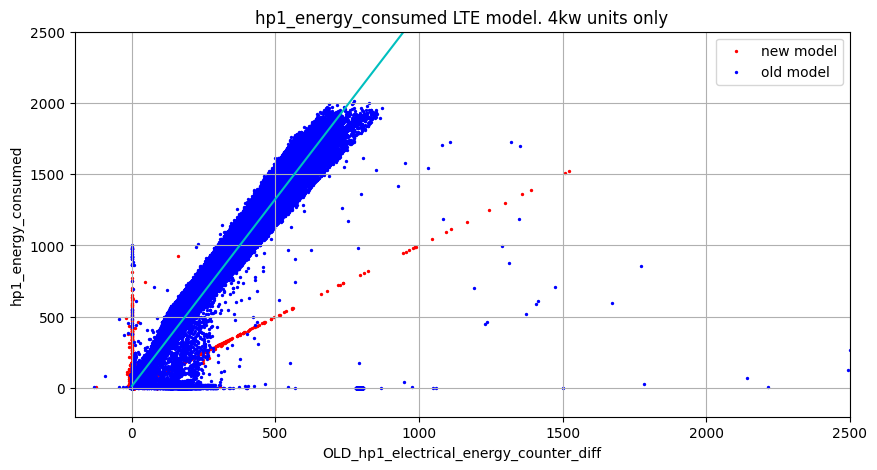

In [69]:
# Flag outliers
def flag_outlier(df, col, threshold=20):
    """
    Flag outliers in a column of a dataframe
    :param df: dataframe
    :param col: column name
    :return: dataframe with new column of outliers based on IQR
    """
    IQR = df[col].astype('float').quantile(0.75) - df[col].astype('float').quantile(0.25)
    lower_fence = df[col].astype('float').quantile(0.25) - (IQR * threshold)
    upper_fence = df[col].astype('float').quantile(0.75) + (IQR * threshold)
    df[f'{col}_outlier'] = np.where((df[col] < lower_fence) | (df[col] > upper_fence), 1, 0)
    return df

# Flag outliers

df = flag_outlier(df, 'OLD_hp1_electrical_energy_counter_diff')
df = flag_outlier(df, 'hp1_energy_consumed')
df['new_model'] = df['quattBuild'].str.startswith('2', na=False).astype(int)

# SELECT ONLY WHERE hp_data_availability > 1 focus only on 4kw units
ax = (df[(df['hp1_data_availability']>0) &
   (df['hp2_data_availability']==0) &
  #  (df['OLD_hp1_electrical_energy_counter_diff_outlier']==0) & 
  #  (df['hp1_energy_consumed_outlier']==0) &
   (df['new_model']==1)]
        [['OLD_hp1_electrical_energy_counter_diff',
          'hp1_energy_consumed','new_model']]
    .plot
    .scatter(x='OLD_hp1_electrical_energy_counter_diff',
             y='hp1_energy_consumed',
             figsize=(20,10), color='red', s=2, label='new model')
)

(df[(df['hp1_data_availability']>0) &
   (df['hp2_data_availability']==0) &
  #  (df['OLD_hp1_electrical_energy_counter_diff_outlier']==0) & 
  #  (df['hp1_energy_consumed_outlier']==0) &
   (df['new_model']==0)]
        [['OLD_hp1_electrical_energy_counter_diff',
          'hp1_energy_consumed','new_model']]
    .plot
    .scatter(x='OLD_hp1_electrical_energy_counter_diff',
             y='hp1_energy_consumed',
             figsize=(10,5), color='blue', ax=ax, s=2, label='old model')
)

ax.set_xlim(-200, 2500)
ax.set_ylim(-200, 2500)

# array of X values
x_line = np.arange(0, 1000, 1)
y_line = linreg.coef_ * x_line + linreg.intercept_
ax.plot(x_line, y_line, 'c-')
plt.grid()
plt.title('hp1_energy_consumed LTE model. 4kw units only')
plt.suptitle(f'y = {linreg.intercept_} + {linreg.coef_[0]} * x')
plt.legend()
plt.show()

In [73]:
linreg.intercept_

14.688471758328376

In [62]:


# set X_train and y_train
X = df[(df['hp1_data_availability']>0) &
   (df['hp2_data_availability']==0) &
   (df['OLD_hp1_electrical_energy_counter_diff_outlier']==0) & 
   (df['hp1_energy_consumed_outlier']==0) &
   (df['new_model']==0) &
   (df['OLD_hp1_electrical_energy_counter_diff'].notna()) &
   (df['hp1_energy_consumed'].notna())]['OLD_hp1_electrical_energy_counter_diff']
y = df[(df['hp1_data_availability']>0) &
   (df['hp2_data_availability']==0) &
   (df['OLD_hp1_electrical_energy_counter_diff_outlier']==0) & 
   (df['hp1_energy_consumed_outlier']==0) &
   (df['new_model']==0) & 
   (df['OLD_hp1_electrical_energy_counter_diff'].notna()) &
   (df['hp1_energy_consumed'].notna())]['hp1_energy_consumed']

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# fit model
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train.values.reshape(-1, 1), y_train)

# Evaluate test model
print("Coefficients = ", list(linreg.coef_) + [linreg.intercept_])
y_train_pred = linreg.predict(X_train.values.reshape(-1, 1))
print("rmse = ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
# print("mse = ", mean_squared_error(y_train, y_train_pred))
print("mae = ", mean_absolute_error(y_train, y_train_pred))

# evaluate model
y_pred = linreg.predict(X_test.values.reshape(-1, 1))

# Evaluate
print("rmse = ", np.sqrt(mean_squared_error(y_test, y_pred)))
# print("mse = ", mean_squared_error(y_train, y_train_pred))
print("mae = ", mean_absolute_error(y_test, y_pred))
# print("r2 = ", linreg.score(X_test, y_test))
# print("mean of errors = ", np.mean(y_test - y_pred))

# array of X values
x_line = np.arange(0, 1000, 1)
y_line = linreg.coef_ * x_line + linreg.intercept_
ax.plot(x_line, y_line, 'c-')
plt.show()

Coefficients =  [2.624344112721547, 14.688471758328376]
rmse =  96.99693172783218
mae =  33.19096147002811
rmse =  104.71222603806746
mae =  34.019274983633224


df['hp1_energy_consumed'].

In [11]:
df_clean = (df[(df['quattBuild']!='2.0.1-production') &
            (df['hp1_data_availability']==1)])

In [16]:
df_clean.sort_values(by='hp1_heat_generated', ascending=False).head(10)

,id,cic_id,created_at,updated_at,time,hp1_energy_consumed,hp1_heat_generated,hp1_active,hp2_energy_consumed,hp2_heat_generated,...,hp1_data_availability,hp2_data_availability,hp1_defrost,OLD_hp1_electrical_energy_counter,OLD_hp2_electrical_energy_counter,OLD_hp1_thermal_energy_counter,OLD_hp2_thermal_energy_counter,OLD_cv_energy_counter,number_of_rows,quattBuild
13215,109965,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:40:38,2023-07-15 05:40:38,2023-02-02 21:00:00,61970.484716,380203.745203,1.00,None,None,...,1,0,0.00,145420.488972,None,739723.930034,None,268127.343755,3653,0.00.44
8212,104962,CIC-28d1c5d1-0166-52e7-9b8d-55c2c5f91109,2023-07-15 00:50:08,2023-07-15 00:50:08,2023-01-24 11:00:00,3035.785475,6863.962067,1.00,None,None,...,1,0,0.00,260897.155140,None,825513.655762,None,95070.769161,2709,0.00.26
13427,110177,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:53:53,2023-07-15 05:53:53,2023-02-11 17:00:00,1715.203623,5836.873330,1.00,None,None,...,1,0,0.00,170343.257389,None,840319.924682,None,327225.512815,3565,0.00.44
13529,110279,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:59:53,2023-07-15 05:59:53,2023-02-15 23:00:00,1735.825640,5772.551252,1.00,None,None,...,1,0,0.00,183411.568167,None,894007.354630,None,342619.717100,3565,0.00.44
13431,110181,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:53:53,2023-07-15 05:53:53,2023-02-11 21:00:00,1695.302042,5713.628079,1.00,None,None,...,1,0,0.00,172471.121694,None,848825.737135,None,327763.098753,3565,0.00.44
13209,109959,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:40:38,2023-07-15 05:40:38,2023-02-02 15:00:00,1655.933208,5668.986170,1.00,None,None,...,1,0,0.00,143982.876305,None,732637.576785,None,267659.936199,3566,0.00.44
13432,110182,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:53:53,2023-07-15 05:53:53,2023-02-11 22:00:00,1727.305078,5599.924204,1.00,None,None,...,1,0,0.00,173108.489222,None,851216.291192,None,327763.098753,3566,0.00.44
13478,110228,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:55:47,2023-07-15 05:55:47,2023-02-13 20:00:00,1794.155109,5511.621923,1.00,None,None,...,1,0,0.00,178326.454694,None,872936.846681,None,336619.258988,3565,0.00.44
13670,110420,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 06:06:51,2023-07-15 06:06:51,2023-02-21 20:00:00,1579.858211,5488.318279,1.00,None,None,...,1,0,0.00,194247.301194,None,951255.391834,None,357944.062376,3566,0.00.44
13479,110229,CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977,2023-07-15 05:55:47,2023-07-15 05:55:47,2023-02-13 21:00:00,1756.033825,5479.492719,1.00,None,None,...,1,0,0.00,178970.161528,None,875274.900968,None,336598.406467,3565,0.00.44


<Axes: xlabel='hp1_energy_consumed', ylabel='hp1_heat_generated'>

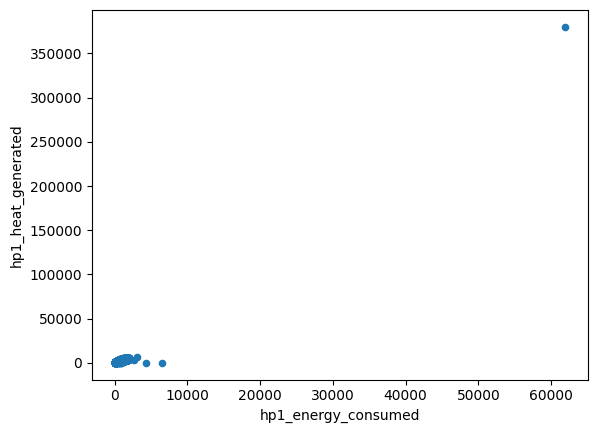

In [14]:
df_clean[['hp1_energy_consumed','hp1_heat_generated']].plot.scatter(x='hp1_energy_consumed',y='hp1_heat_generated')

In [21]:
# convert to pandas dataframe
df = pd.DataFrame(result)
# drop rows where created_at < 2023-07-13
df = df[df['created_at'] > '2023-07-13']

# add columns with diff of old counters
df['OLD_hp1_energy_consumed'] = (df.groupby('cic_id', sort='time')
                                 ['OLD_hp1_electrical_energy_counter'].diff())
df['OLD_hp2_energy_consumed'] = (df.groupby('cic_id', sort='time')
                                 ['OLD_hp2_electrical_energy_counter'].diff())
df['OLD_hp1_energy_generated'] = (df.groupby('cic_id', sort='time')
                                 ['OLD_hp1_thermal_energy_counter'].diff())
df['OLD_hp2_energy_generated'] = (df.groupby('cic_id', sort='time')
                                 ['OLD_hp2_thermal_energy_counter'].diff())
df['boiler_heat_generated'] = (df.groupby('cic_id', sort='time')
                                 ['OLD_cv_energy_counter'].diff())

In [20]:
df.iloc[42630:42639][['time','OLD_hp1_energy_consumed','hp1_energy_consumed','OLD_hp1_electrical_energy_counter']]

,time,OLD_hp1_energy_consumed,hp1_energy_consumed,OLD_hp1_electrical_energy_counter
42630,2023-07-06 08:00:00,-9.030361,4.926565,0.000000
42631,2023-07-06 09:00:00,0.000000,46.244372,0.000000
42632,2023-07-06 08:00:00,9.000000,4.926565,9.000000
42633,2023-07-06 09:00:00,-10.000000,46.244372,-1.000000
42634,2023-03-09 01:00:00,397719.409001,692.658385,397719.409001
42635,2023-03-09 02:00:00,345.129389,1075.548447,398064.538390
42636,2023-03-09 03:00:00,460.456555,1369.906608,398524.994945
42637,2023-03-09 04:00:00,429.095695,1295.311705,398954.090640
42638,2023-03-09 05:00:00,490.412055,1451.793790,399444.502695


In [22]:
df.sort_values(by=['OLD_hp1_energy_consumed'], ascending=False).head(20)

,id,cic_id,created_at,updated_at,time,hp1_energy_consumed,hp1_heat_generated,hp1_active,hp2_energy_consumed,hp2_heat_generated,...,OLD_hp2_electrical_energy_counter,OLD_hp1_thermal_energy_counter,OLD_hp2_thermal_energy_counter,OLD_cv_energy_counter,number_of_rows,quattBuild,OLD_hp1_energy_consumed,OLD_hp2_energy_consumed,OLD_hp1_energy_generated,OLD_hp2_energy_generated
59742,59859,CIC-a17b541d-ab55-50d9-9352-7412e372165f,2023-07-13 13:50:09,2023-07-13 13:50:09,2023-01-06 15:00:00,406.335972,1640.349358,0.93,None,None,...,None,734317.443627,None,270637.450837,1551,0.00.26,374299.268750,NaN,734263.027814,NaN
59735,59852,CIC-a17b541d-ab55-50d9-9352-7412e372165f,2023-07-13 13:49:51,2023-07-13 13:49:51,2022-12-04 14:00:00,681.333890,0.000000,0.87,None,None,...,None,54.415813,None,9429.688313,2647,0.00.26,48975.713639,NaN,0.000000,NaN
59771,59888,CIC-a17b541d-ab55-50d9-9352-7412e372165f,2023-07-13 13:50:46,2023-07-13 13:50:46,2023-01-12 10:00:00,2.328688,0.255320,0.00,None,None,...,None,988734.574667,None,267663.109115,191,0.00.26,44458.596696,NaN,215958.043494,NaN
88405,88522,CIC-32212ec5-f432-55d7-9289-ee3f4d8ed61a,2023-07-14 10:05:39,2023-07-14 10:05:39,2023-04-30 08:00:00,25.484625,66.138310,0.02,None,None,...,None,1148728.639279,None,383565.226907,3324,0.00.26,27210.999055,NaN,141119.445633,NaN
66791,66908,CIC-d170ab27-61af-5d53-886b-41082b7376f1,2023-07-13 16:01:16,2023-07-13 16:01:16,2023-03-23 01:00:00,2.084557,0.000000,0.00,None,None,...,None,2048018.733260,None,169416.022685,1494,0.00.26,7596.356695,NaN,46139.335273,NaN
65493,65610,CIC-d170ab27-61af-5d53-886b-41082b7376f1,2023-07-13 15:35:29,2023-07-13 15:35:29,2023-01-22 10:00:00,6.203810,0.000000,0.00,None,None,...,None,1107501.359402,None,107511.772893,1746,0.00.26,6683.511500,NaN,23490.796425,NaN
64102,64219,CIC-d170ab27-61af-5d53-886b-41082b7376f1,2023-07-13 15:06:57,2023-07-13 15:06:57,2022-11-23 19:00:00,37.380461,193.880620,0.56,None,None,...,None,53175.226385,None,5880.457391,534,0.00.26,4096.721806,NaN,24538.189725,NaN
64044,64161,CIC-d170ab27-61af-5d53-886b-41082b7376f1,2023-07-13 15:05:45,2023-07-13 15:05:45,2022-11-18 11:00:00,None,None,0.99,None,None,...,None,33976.399905,None,4780.956815,2355,None,3728.591305,NaN,25952.782818,NaN
87057,87174,CIC-32212ec5-f432-55d7-9289-ee3f4d8ed61a,2023-07-14 08:48:21,2023-07-14 08:48:21,2023-02-09 16:00:00,697.583076,1781.101749,1.00,None,None,...,None,284184.560402,None,99353.150784,1539,0.00.26,3668.769722,NaN,15018.797849,NaN
79307,79424,CIC-31f9bb1b-799a-55a5-9ecc-0cc4fffc5e30,2023-07-14 02:07:35,2023-07-14 02:07:35,2023-03-10 01:00:00,None,None,0.00,None,None,...,None,305192.555134,None,83077.000610,31,None,2660.846166,NaN,9667.817570,NaN


<Axes: xlabel='OLD_hp1_energy_consumed', ylabel='hp1_energy_consumed'>

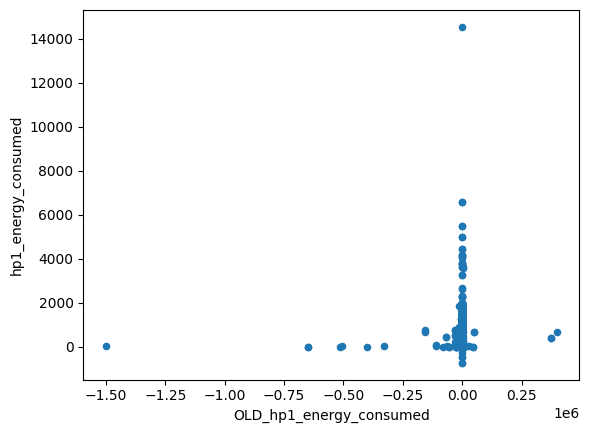

In [15]:
# for each counter, research how the counter relates to other columns in the frame
# scatter OLD_hp1_energy_consumed vs hp1_energy_consumed

df[['OLD_hp1_energy_consumed', 'hp1_energy_consumed']].plot.scatter(x='OLD_hp1_energy_consumed', y='hp1_energy_consumed')